# Utils

In [56]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

In [57]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
def correct_types(df, column='SO_Omschrijving'):
    """
    Preprocess the specified column in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)
    return df

def replace_punctuation(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def remove_numerical_values(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Initialize stemmer.
    # stemmer = SnowballStemmer("dutch")

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values(replace_punctuation(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_items(description):
    """
    Group items in a description based on predefined lookup lists.

    Parameters:
    - description (str): The input description to be categorized.

    Returns:
    str: The category type of the description based on predefined lookup lists.
         If no match is found, 'Unknown' is returned.

    Example:
    >>> group_items("This is a description containing heating keywords.")
    'heating'
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Order lookup lists by length in descending order.
    lookup_lists = sorted(lookup_lists, key=lambda x: len(globals()[x]), reverse=True)

    for lookup_list_name in lookup_lists:
        lookup_list = globals()[lookup_list_name]

        for word in lookup_list:
            if word in description:
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name
    return 'Unknown'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'
    
    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)
    
    # Return True if a match is found, False otherwise.
    return bool(match)

In [59]:
lookup_heating = [
    "ketel",
    "CV",
    "c.v.",
    "c.v",
    "Kachel",
    "verwarming",
    "radiatoren",
    "radiator",
    "vloerverwarming",
    "rookgasventilator"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "heating": "heating",
    "heating": "Heating",
    "cooling": "Cooling"
}

# Data Reading

In [60]:
path = './Navision Serviceorder data.xlsx'

# Read the Excel file into a DataFrame.
df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

# This dataframe is used for testing purposes.
df_original = df_so.copy()
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]


# Data Cleaning

In [61]:
# Create a copy from the original dataset.
df_so_cleaned = correct_types(df_so, column='SO_Omschrijving')

# Replace punctuations.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(replace_punctuation)

# Remove numerical values.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(remove_numerical_values)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
# stop_words.discard('niet')
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(stemize)

df_so_cleaned.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,storing stoombevochtiger ruimt,44608,44609.0,154.18
1,wasbak pantry ruimt loopt slecht,44624,44624.0,229.58
2,storing bevochtiger lbk link,44627,44628.0,188.14
3,afzuig schakelar werkt niet keuk,44704,44704.0,250.17
4,snaarbreuk afzuigvent lbk recht,44742,44746.0,447.16


# Modules Grouping

In [62]:
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(group_items)
categorized_count = 0
for _, value in module_names.items():
    categorized_count = categorized_count + len(df_so_cleaned["target"][df_so_cleaned["target"] == value])
    print(f'{value} count: {len(df_so_cleaned["target"][df_so_cleaned["target"] == value])}')

Complaints count: 0
Regular Maintenance count: 0
Fault Redemption count: 0
Domestic Water count: 0
Office count: 0
Water Distribution count: 0
BMS count: 0
WKK count: 0
Elevator count: 0
Lighting count: 0
Heat Pump count: 0
Sanitary count: 0
Fire Safety count: 0
Shading count: 0
Entrance count: 0
Heating count: 1094
Cooling count: 0


In [63]:
df_so_heating = df_so_cleaned[df_so_cleaned["target"].isin(["Heating"])]
df_so_heating.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target
62,radiator niet warm,43760,43936.0,572.13,Heating
64,storing cv ketel,43780,43810.0,826.69,Heating
67,cv ketel geeft foutcod grag nakijk,43838,43839.0,239.91,Heating
72,cv ketel geeft foutcod grag nakijk,43887,43887.0,0.00,Heating
80,verwarmingsklep blijft hang priva system,44071,44657.0,724.71,Heating


# Preparation

In [64]:
# Split transaction strings into lists.
transactions = df_so_heating['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert DataFrame column into list of strings.
transactions_heating = list(transactions)

print(transactions_heating)

[['radiator', 'niet', 'warm'], ['storing', 'cv', 'ketel'], ['cv', 'ketel', 'geeft', 'foutcod', 'grag', 'nakijk'], ['cv', 'ketel', 'geeft', 'foutcod', 'grag', 'nakijk'], ['verwarmingsklep', 'blijft', 'hang', 'priva', 'system'], ['storing', 'vaillant', 'ketel', 'torenpad', 'wachter'], ['lekkend', 'radiator'], ['lekkend', 'radiator'], ['thermostatisch', 'radiatorkran', 'lekt', 'restaurant'], ['iv', 'ketel', 'storing'], ['storing', 'ketel'], ['mp', 'cv', 'ketel', 'storing', 'regelkast', 'mak', 'herrie'], ['storing', 'verwarmingsinstallatie'], ['uitvall', 'ketel'], ['cv', 'storing', 'ketel'], ['storing', 'ketel', 'technisch', 'ruimt'], ['storing', 'ketel'], ['radiator', 'niet', 'warm'], ['ker', 'storing', 'cv', 'ketel', 'water', 'bijvull'], ['ketel', 'stat', 'storing'], ['cv', 'ketel', 'werkt', 'niet', 'cod'], ['beid', 'ketel', 'gev', 'water', 'erin'], ['ketel', 'achtergevel', 'storing'], ['ketel', 'achtergevel', 'storing'], ['ketel', 'defect'], ['ketel', 'defect'], ['ketel', 'maakt', 'gelu

In [65]:
# Instantiate transaction encoder and identify unique items in transactions.
encoder = TransactionEncoder().fit(transactions_heating)

# One-hot encode transactions.
onehot_heating = encoder.transform(transactions_heating)
onehot_heating = pd.DataFrame(onehot_heating, columns=encoder.columns_)

# Algorithm

**Itemsets Creation**

In [66]:
# Compute frequent itemsets using the Apriori algorithm.
n = 10
frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  n/len(onehot_heating),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')

frequent_itemsets_heating = frequent_itemsets_heating.sort_values(by=['support'], ascending=False).reset_index(drop=True)
length_1 = len(frequent_itemsets_heating[frequent_itemsets_heating['itemsets'].apply(lambda x: len(x)) == 1])
length_2 = len(frequent_itemsets_heating[frequent_itemsets_heating['itemsets'].apply(lambda x: len(x)) == 2])
length_3 = len(frequent_itemsets_heating[frequent_itemsets_heating['itemsets'].apply(lambda x: len(x)) == 3])
length_more_than_3 = len(frequent_itemsets_heating[frequent_itemsets_heating['itemsets'].apply(lambda x: len(x)) > 3])
print(f'Number of frequent itemsets with length 1: {length_1}')
print(f'Number of frequent itemsets with length 2: {length_2}')
print(f'Number of frequent itemsets with length 3: {length_3}')
print(f'Number of frequent itemsets with length more than 3: {length_more_than_3}')
frequent_itemsets_heating.head()

Processing 15 combinations | Sampling itemset size 543
Number of transactions: 1094
Number of frequent itemsets: 165
Number of frequent itemsets with length 1: 62
Number of frequent itemsets with length 2: 73
Number of frequent itemsets with length 3: 27
Number of frequent itemsets with length more than 3: 3


,support,itemsets
0,0.553016,(ketel)
1,0.366545,(storing)
2,0.325411,"(storing, ketel)"
3,0.255027,(radiator)
4,0.193784,(cv)


**Rules Creation**

In [82]:
# Compute all association rules for frequent_itemsets.
rules_heating = association_rules(frequent_itemsets_heating, 
                            metric = "lift", 
                         	min_threshold = 1)

rules_heating = rules_heating.sort_values(by=['support'], ascending=False).reset_index(drop=True)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')
print(f'Number of rules: {len(rules_heating)}')

# Sort rules based on conviction.
rules_heating = rules_heating.sort_values(by=['conviction'], ascending=False).reset_index(drop=True)

rules_heating.head(50)

Number of transactions: 1094
Number of frequent itemsets: 149
Number of rules: 270


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(12kg1),(ketel),0.010055,0.553016,0.010055,1.000000,1.808264,0.004494,inf,0.451524
1,"(warm, mp)",(radiator),0.010969,0.255027,0.010969,1.000000,3.921147,0.008172,inf,0.753235
2,(achtergevel),(ketel),0.011883,0.553016,0.011883,1.000000,1.808264,0.005312,inf,0.452359
3,"(warm, mp)","(niet, radiator)",0.010969,0.074040,0.010969,1.000000,13.506173,0.010157,inf,0.936229
4,(goed),(niet),0.010969,0.103291,0.010969,1.000000,9.681416,0.009836,inf,0.906654
5,(doorbrand),(blijft),0.011883,0.035649,0.011883,1.000000,28.051282,0.011459,inf,0.975948
6,"(storing, water)",(ketel),0.010969,0.553016,0.010969,1.000000,1.808264,0.004903,inf,0.451941
7,(12kg1),(storing),0.010055,0.366545,0.010055,1.000000,2.728180,0.006369,inf,0.639889
8,"(cv, mp)",(ketel),0.011883,0.553016,0.011883,1.000000,1.808264,0.005312,inf,0.452359
9,"(12kg1, storing)",(ketel),0.010055,0.553016,0.010055,1.000000,1.808264,0.004494,inf,0.451524


**Test Section**

In [68]:
rule_index = 3
word_list = list(rules_heating.iloc[rule_index]['antecedents'])
word_list.extend(list(rules_heating.iloc[rule_index]['consequents']))
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 203 items
64                                        Storing cv ketel.
67                 CV ketel geeft foutcode 5 graag nakijken
67                 CV ketel geeft foutcode 5 graag nakijken
936        (MP)CV ketel op storing en regelkast maak herrie
959                                      cv storing ketel 1
976              2e keer storing CV ketel , water bijvullen
1000                         CV ketel werkt niet (code: 0).
1072                                 storing c.v. ketel RK2
1133          vervangen van terugslagklep Remeha c.v. ketel
1248                storing c.v. ketel pand KW, Remeha 5.29
1332                                Storing cv ketel status
1559                                      Cv- Ketel storing
1584                         Brander defect van de CV ketel
1585               Inspectie luik defect van cv ketel wd 40
1585               Inspectie luik defect van cv ketel wd 40
1683                                  (IV) Storing cv-ketel
1694        

# Analysis

In [69]:
df_original = pd.read_excel(path)
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]

In [70]:
flag = rules_heating[rules_heating['lift'] < 1].copy()
print(len(flag))

0


In [71]:
rules_one_consequent = rules_heating[rules_heating['antecedents'].apply(len) == 2]
print(len(rules_one_consequent))
rules_one_consequent.head(60)

93


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
9,"(ketel, cv)",(storing),0.185558,0.366545,0.096892,0.522167,1.424567,0.028877,1.325685,0.365934
10,"(storing, cv)",(ketel),0.097806,0.553016,0.096892,0.990654,1.791365,0.042804,47.827239,0.489658
11,"(storing, ketel)",(cv),0.325411,0.193784,0.096892,0.297753,1.536517,0.033833,1.148051,0.517615
23,"(niet, warm)",(radiator),0.037477,0.255027,0.036563,0.975610,3.825509,0.027005,30.543876,0.767355
24,"(niet, radiator)",(warm),0.074040,0.064899,0.036563,0.493827,7.609111,0.031758,1.847394,0.938031
25,"(warm, radiator)",(niet),0.044790,0.103291,0.036563,0.816327,7.903197,0.031937,4.882084,0.914426
32,"(radiator, mp)",(niet),0.051188,0.103291,0.023766,0.464286,4.494943,0.018479,1.673857,0.819475
36,"(niet, radiator)",(mp),0.074040,0.094150,0.023766,0.320988,3.409325,0.016795,1.334070,0.763194
37,"(niet, mp)",(radiator),0.028336,0.255027,0.023766,0.838710,3.288704,0.016539,4.618830,0.716224
43,"(niet, radiator)",(werkt),0.074040,0.031993,0.021024,0.283951,8.875485,0.018655,1.351872,0.958281


In [72]:
word_list = list(rules_heating.iloc[0]['antecedents'])
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 3096 items
0                      storing stoombevochtiger ruimte 4.29
2                        Storing bevochtiger van LBK-Links.
18                 Storing MER Comp.2 Lage Druk 03_103CCU02
30               Storing Snaarbreuk afzuigvent. 04_100PdT02
32                       lagedruk storing comp.2 mer ruimte
36                   Stoomomvormer RK3 LBK links in storing
38                                 Storing warmte opwekking
40                                              Storing LBK
42                                              Storing WKO
46         Werkplaats heaters/zwarte buiskachels op storing
47                    Storing aan de verwarming spuitcabine
49                                               cv storing
55                       Ventilatiesysteem staat in storing
64                                        Storing cv ketel.
49                                               cv storing
74                         Storing alarminstallatie Collier
75         

# Visualization

**Heatmap**

Processing 24 combinations | Sampling itemset size 43
Number of rules: 62
number of frequent itemsets: 61
Number of association rules: 62


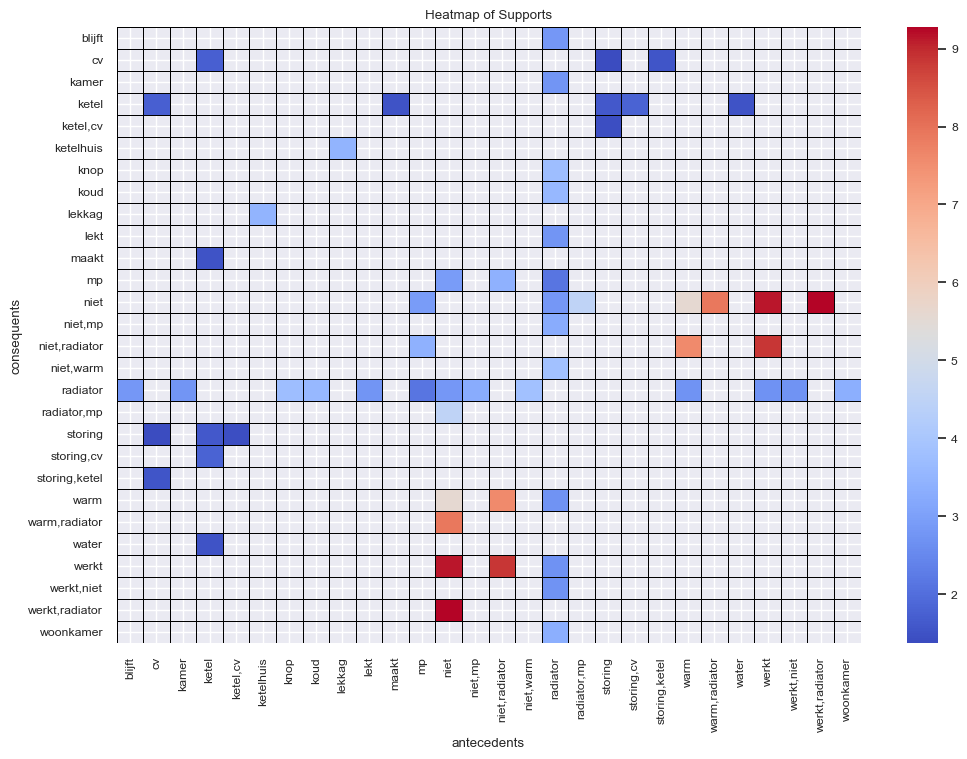

In [73]:
frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  20/len(onehot_heating),
                            use_colnames = True,
                            verbose = 1)

rules_heating = association_rules(frequent_itemsets_heating, metric = 'lift', min_threshold = 1)

print(f'Number of rules: {len(rules_heating)}')
print(f'number of frequent itemsets: {len(frequent_itemsets_heating)}')
print(f'Number of association rules: {len(rules_heating)}')

# Replace frozen sets with strings.
rules_heating['antecedents'] = rules_heating['antecedents'].apply(lambda a: ','.join(list(a)))
rules_heating['consequents'] = rules_heating['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_heating.pivot(index='consequents', columns='antecedents', values='lift')
sns.set(font_scale=0.8)  # Adjust the font size as needed
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')

plt.title('Heatmap of Supports')
plt.yticks(rotation=0)
plt.show()

**Antecedent-Consequent Support Scatterplot**

Processing 15 combinations | Sampling itemset size 543
Number of transactions: 1094
Number of frequent itemsets: 165
Minimum support: 0.009140767824497258
Number of rules: 312


<Axes: xlabel='antecedent support', ylabel='consequent support'>

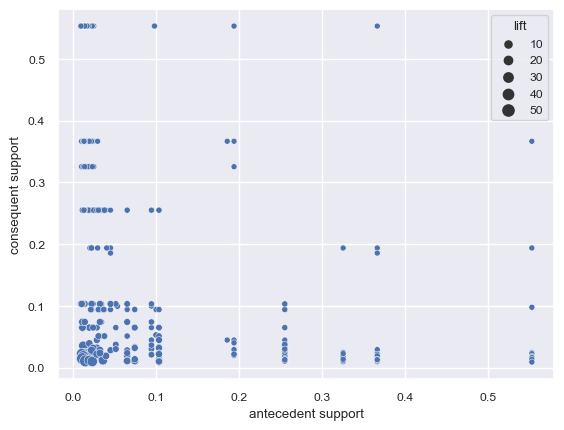

In [74]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  10/len(onehot_heating), # Happenning at least 10 times.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')

rules_heating = association_rules(frequent_itemsets_heating, metric = 'lift', min_threshold = 1)
print(f"Minimum support: {rules_heating['support'].min()}")

print(f'Number of rules: {len(rules_heating)}')

sns.scatterplot(x='antecedent support', y='consequent support', size='lift', data=rules_heating)

**Support-Confidence Scatterplot**

Processing 413 combinations | Sampling itemset size 7654
Number of transactions: 1094
Number of frequent itemsets: 2548
Number of rules: 15788


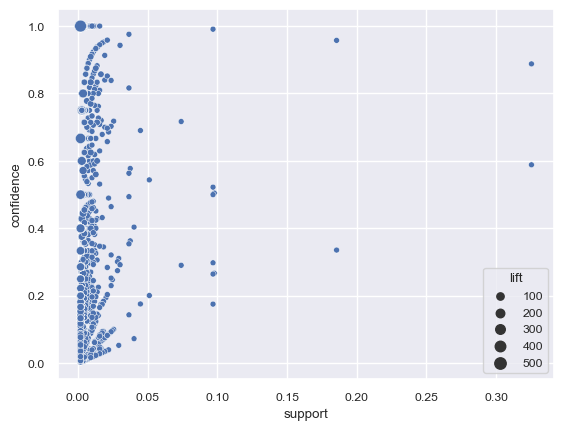

In [75]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  0.001, # Happenning at least 10 times.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')

rules_heating = association_rules(frequent_itemsets_heating, metric = 'support', 
                          min_threshold = 0.000001)

print(f'Number of rules: {len(rules_heating)}')

sns.scatterplot(x = "support", y = "confidence", size='lift', data = rules_heating)
plt.show()

**Support-Lift Scatterplot**

Processing 15 combinations | Sampling itemset size 543
Number of transactions: 1094
Number of frequent itemsets: 165
Number of rules: 312


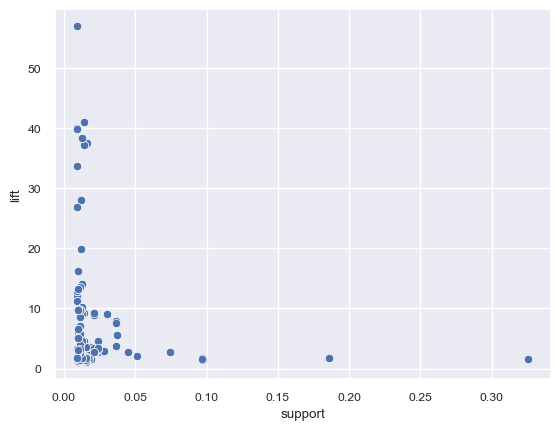

In [76]:
n = 10

frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  n/len(onehot_heating),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')

rules_heating = association_rules(frequent_itemsets_heating, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of rules: {len(rules_heating)}')

sns.scatterplot(x = "support", y = "lift", data = rules_heating)
plt.show()

**Parallel-Coordinates Plot**

Processing 4 combinations | Sampling itemset size 4 3
Number of transactions: 1094
Number of frequent itemsets: 29
Number of rules: 30


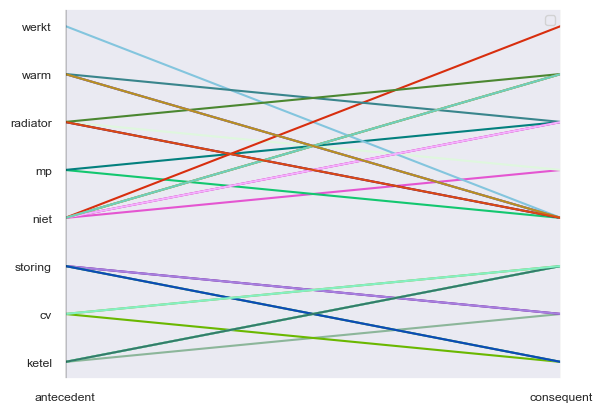

In [84]:
n = 30
frequent_itemsets_heating = apriori(onehot_heating, 
                            min_support =  n/len(onehot_heating),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

rules_heating = association_rules(frequent_itemsets_heating, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of transactions: {len(onehot_heating)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')
print(f'Number of rules: {len(rules_heating)}')

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules_heating)

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.show()

# Final Result

In [78]:
n = 11

# Finding frequent itemsets.
min_support = n / len(onehot_heating)
frequent_itemsets_heating = apriori(onehot_heating, 
                                        min_support=min_support,
                                        use_colnames=True,
                                        verbose=1)

# Generating association rules.
rules_heating = association_rules(frequent_itemsets_heating, 
                                       metric='lift', 
                                       min_threshold=1)

# Displaying information.
num_transactions = len(onehot_heating)
print(f'Number of transactions: {num_transactions}')
print(f'Minimum itemset support: {min_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')

# Sorting rules by support.
rules_heating = rules_heating.sort_values(by='support', ascending=False).reset_index(drop=True)

# Removing duplicate rules.
duplicates = set()
for i, row in rules_heating.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    for j, r in rules_heating.iloc[i+1:].iterrows():
        if consequent.union(antecedent) == r['antecedents'].union(r['consequents']):
            duplicates.add(j)

rules_heating.drop(index=duplicates, inplace=True)
rules_heating.reset_index(drop=True, inplace=True)

print(f'Number of rules: {len(rules_heating)}')
rules_heating

Processing 5 combinations | Sampling itemset size 5 43
Number of transactions: 1094
Minimum itemset support: 0.010054844606946984
Number of frequent itemsets: 149
Number of rules: 81


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ketel),(storing),0.553016,0.366545,0.325411,0.588430,1.605342,0.122706,1.539118,0.843610
1,(ketel),(cv),0.553016,0.193784,0.185558,0.335537,1.731499,0.078392,1.213335,0.945148
2,(cv),(storing),0.193784,0.366545,0.097806,0.504717,1.376959,0.026776,1.278976,0.339564
3,"(storing, ketel)",(cv),0.325411,0.193784,0.096892,0.297753,1.536517,0.033833,1.148051,0.517615
4,(radiator),(niet),0.255027,0.103291,0.074040,0.290323,2.810734,0.047698,1.263545,0.864758
...,...,...,...,...,...,...,...,...,...,...
76,(radiator),(badkamer),0.255027,0.013711,0.010055,0.039427,2.875508,0.006558,1.026771,0.875516
77,(storing),(12kg1),0.366545,0.010055,0.010055,0.027431,2.728180,0.006369,1.017867,1.000000
78,(ketel),"(storing, warm)",0.553016,0.011883,0.010055,0.018182,1.530070,0.003483,1.006415,0.775051
79,(ketel),"(stat, storing)",0.553016,0.010969,0.010055,0.018182,1.657576,0.003989,1.007346,0.887526


In [79]:
rule_indices = list(range(0, len(rules_heating)))
rule_indices

# Set the maximum width of the columns.
pd.set_option('display.max_colwidth', None)

for row_index in rule_indices:
    word_list = list(rules_heating.iloc[row_index]['antecedents'])
    word_list.extend(list(rules_heating.iloc[row_index]['consequents']))
    indices = []
    for transaction in df_so['SO_Omschrijving']:
        if all(contains_word_regex(transaction, word) for word in word_list):
            indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
        print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}\n\n")

Original Dataset: 356 items
64                                        Storing cv ketel.
86               Storing Vaillant ketel Torenpad De Wachter
886                                   (IV) Ketel in storing
924                                           Storing ketel
936        (MP)CV ketel op storing en regelkast maak herrie
959                                      cv storing ketel 1
960                      Storing ketel 1 technische ruimte.
924                                           Storing ketel
976              2e keer storing CV ketel , water bijvullen
989                                  Ketel staat in storing
1041                     Ketel achtergevel storing in / uit
1041                     Ketel achtergevel storing in / uit
1051                      Storing ketel achtergevel hoog in
924                                           Storing ketel
1072                                 storing c.v. ketel RK2
1080                                     (RA) Storing ketel
1080        